This kernel is a forked from [BigQuery Machine Learning Tutorial](https://www.kaggle.com/rtatman/bigquery-machine-learning-tutorial) and serves as a starting point for the [BigQuery-Geotab Intersection Congestion](https://www.kaggle.com/c/bigquery-geotab-intersection-congestion/) competition.

## What is BigQuery ML and when should you use it?

BigQuery Machine Learning (BQML) is a toolset that allows you to train and serve machine learning models directly in BigQuery. This has several advantages: 

* **You don't have to read your data into local memory.** One question I get a lot is "how can I train my ML model if my dataset is just too big to fit on my computer?". You can subsample your dataset, of course, but you can also use tools like BQML that train your model directly in your database.
* **You don't have to use multiple languages.** Particularly if you're working in a team where most of your teammates don't know  Python or R or your preferred language for modelling, working in SQL can make it easier for you to collaborate.
* **You can serve your model immediately after it's trained.** Because your model is already in the same place as your data, you can make predictions directly from your database. This lets you get around the hassle of cleaning up your code and either putting it intro production or passing it off to your engineering colleagues.

BQML probably won't replace all your modelling tools, but it's a nice quick way to train and serve a model without spending a lot of time moving code or data around. 

### Models supported by BQML

One limitation of BQML is that a limited number of model types are supported. As of September 10, 2019, [BQML supports the following types of models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#model_type). More model types are being built out, though, so check the documentation for the most up-to-date information.

* Linear regression (LINEAR_REG). This is the OG modelling technique, used to predict the value of a continuous variable. This is what you'd use for questions like "how many units can we expect a custom to buy?". 
* Logistic regression (LOGISTIC_REG). This regression technique lets you classify which category an observation fits in to. For example, "will this person buy the blue one or the red one?". 
* K-means (KMEANS). This is an unsupervised clustering algorithm. It lets you identify categories. For example, "given all of the customers in our database, how could we identify five distinct groups?".
* Tensorflow (TENSORFLOW). If you've already got a trained TensorFlow model, you can upload it to BQML and serve it directly from there. You can read more about this in [the documentation](https://cloud.google.com/bigquery-ml/docs/making-predictions-with-imported-tensorflow-models). You can't currently train a TensorFlow model in BQML.

## Step zero: Gain access to dataset

To gain access to this competition's dataset on BigQuery, you must: 
1. Join the open google group provisioned for access to the private dataset. First follow this link: https://groups.google.com/d/forum/bigquery-geotab 
2. Log in with a Google account. 
3. Click on Join group in the pop-up that appears. 
4. You will now have access to query the dataset kaggle-competition-datasets.geotab_intersection_congestion.train. NOTE: This is NOT an email distribution list. So once you see You cannot view topics in this forum after joining the group, you do not need to take any further action and can proceed to access the dataset. 
5. You can now access the dataset and run this kernel

## Step one: Setup and create your dataset

First, you'll need to enable BigQuery in this Kernel. You can do this by toggling BigQuery under settings in the right bar.

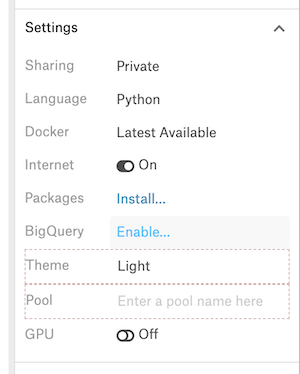

In order to create BigQuery ML models, you'll have to link a Google Cloud Platform account.

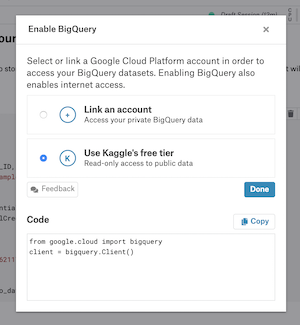

After you've connected an account, you'll need to [create a project in Google Cloud Platform](https://cloud.google.com/resource-manager/docs/creating-managing-projects) and replace the placeholder below with your project ID. At which point, you can create a BigQuery dataset to store your ML model. You don't actually have to upload any data; the only table in it will be the one with your trained model.

In [ ]:
# Replace 'kaggle-competitions-project' with YOUR OWN project id here --  
PROJECT_ID = 'kaggle-competitions-project'

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('bqml_example', exists_ok=True)

from google.cloud.bigquery import magics
from kaggle.gcp import KaggleKernelCredentials
magics.context.credentials = KaggleKernelCredentials()
magics.context.project = PROJECT_ID

# create a reference to our table
table = client.get_table("kaggle-competition-datasets.geotab_intersection_congestion.train")

# look at five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

## Step two: Create your model

Next, we will create a linear regression model.

The standard SQL query uses a `CREATE MODEL` statement to create and train the model. You can [find the documentation for this fuction here](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#model_type). 

The BigQuery Python client library provides a custom magic command so that you don't need to set up the queries yourself. To load the magic commands from the
client library, run the following code.

In [ ]:
%load_ext google.cloud.bigquery

> `%load_ext` is one of the many Jupyter built-in magic commands. See the
[Jupyter documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html) for more
information about `%load_ext` and other magic commands.

The BigQuery client library provides a cell magic,
`%%bigquery`, which runs a SQL query and returns the results as a Pandas
DataFrame. Once you use this command the rest of your cell will be treated as a SQL command. (Note that tab complete won't work for SQL code written in this way.)

Here's the the query that will train our model:

In [ ]:
%%bigquery
CREATE MODEL IF NOT EXISTS `bqml_example.model1`
OPTIONS(model_type='linear_reg') AS
SELECT
    TotalTimeStopped_p20 as label,
    Weekend,
    Hour,
    EntryHeading,
    ExitHeading,
    City
FROM
  `kaggle-competition-datasets.geotab_intersection_congestion.train`
WHERE
    RowId < 2600000

Let's break down this command a little bit. 

This line is writing our model to BigQuery. (The fact that BQML requires write permissions is why you needed to set up your GCP account; the default Kaggle connection doesn't allow you write tables, only query them. 

    %%bigquery
    CREATE MODEL IF NOT EXISTS `bqml_example.model1`
    
Here we're specifying that our model will be linear regression. Next we need to actually define our model.

    OPTIONS(model_type='linear_reg') AS
    
The code under the SELECT clause is where we define the variable we're trying to predict as well as what variables we want to use to predict it.

The column we alias as "label" will be our dependent variable, the thing we're trying to predict. 

The other five rows say what information we want to use to predict that label. For this example, we're creating a model using information of whether it's the weekend, what hour of the day it is, the entry direction, the exit direction and the city.
    
    SELECT
        TotalTimeStopped_p20 as label,
        Weekend,
        Hour,
        EntryHeading,
        ExitHeading,
        City
      
The FROM clause specifies the table (in this case more than one table) that we're going to get our data from.

    FROM
      `kaggle-competition-datasets.geotab_intersection_congestion.train`
      
And finally the `WHERE` clause specifies the range of rows we're using to train our model.

    WHERE
      RowId < 2600000
      

The query takes several minutes to complete. After the first iteration is
    complete, your model (`model1`) appears in the navigation panel of the
    BigQuery UI. Because the query uses a `CREATE MODEL` statement to create a
    table, you do not see query results. The output is an empty string.

## Step three: Get training statistics

To see the results of the model training, you can use the
[`ML.TRAINING_INFO`](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)
function, or you can view the statistics in the BigQuery UI.
In this tutorial, you use the `ML.TRAINING_INFO` function.

A machine learning algorithm builds a model by examining many examples and
attempting to find a model that minimizes loss. This process is called empirical
risk minimization.

Loss is the penalty for a bad prediction &mdash; a number indicating
how bad the model's prediction was on a single example. If the model's
prediction is perfect, the loss is zero; otherwise, the loss is greater. The
goal of training a model is to find a set of weights that have low
loss, on average, across all examples.

To see the model training statistics that were generated when you ran the
`CREATE MODEL` query, run the following:

In [ ]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_example.model1`)
ORDER BY iteration 

> Note: Typically, it is not a best practice to use a `SELECT *` query. Because the model output is a small table, this query does not process a large amount of data. As a result, the cost is minimal.

The `loss` column represents the loss metric calculated after the given iteration
    on the training dataset. 
    The `eval_loss` column is the same loss metric calculated on
    the holdout dataset (data that is held back from training to validate the model).
    
At this point you'll notice that BQML has taken care of some of the common ML decisions for you:

* Splitting into training & evaluation datasets to help detect overfitting
* Early stopping (stopping training when additional iterations would not improve performance on the evaluation set)
* Picking and updating learning rates (starting with a low learning rate and increasing it over time)
* Picking an optimization strategy (batch gradient descent for large datasets with high cardinality, normal equation for small datasets where it would be faster)

For more details on the `ML.TRAINING_INFO` function, see the
    [BQML syntax reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train).


## Step four: Evaluate your model

After creating your model, you can evaluate the performance of the model using
the [`ML.EVALUATE`](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
function.

In [ ]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `bqml_example.model1`, (
  SELECT
    TotalTimeStopped_p20 as label,
    Weekend,
    Hour,
    EntryHeading,
    ExitHeading,
    City
  FROM
    `kaggle-competition-datasets.geotab_intersection_congestion.train`
  WHERE
    RowId > 2600000))

## Step five: Use your model to predict outcomes

Now that you have evaluated your model, the next step is to use it to predict
outcomes.

In [ ]:
%%bigquery df
SELECT
  RowId,
  predicted_label as TotalTimeStopped_p20
FROM
  ML.PREDICT(MODEL `bqml_example.model1`,
    (
    SELECT
        RowId,
        Weekend,
        Hour,
        EntryHeading,
        ExitHeading,
        City
    FROM
      `kaggle-competition-datasets.geotab_intersection_congestion.test`))
    ORDER BY RowId ASC

## Step six: Output as CSV

Let's format the results to fit the submission schema. The [format of the submission file](https://www.kaggle.com/c/bigquery-geotab-intersection-congestion/data) requires that the header be: `TargetId` and `Target` for the predictions column. Since each of the results provided by this model is for TotalTimeStopped_p20, they'll have a TargetId of {RowID}_0 and the Target will be the predicted value for TotalTimeStopped_p20.

In [ ]:
df['RowId'] = df['RowId'].apply(str) + '_0'
df.rename(columns={'RowId': 'TargetId', 'TotalTimeStopped_p20': 'Target'}, inplace=True)
df

Finally, you'll want to output the results as a CSV. 

In [ ]:
df.to_csv(r'submission.csv')

## Step seven: Repeat

You'll want to repeat this process for each of the metrics that is evaluated, namely TotalTimeStopped_p50, TotalTimeStopped_p80, DistanceToFirstStop_p20, DistanceToFirstStop_p50 and DistanceToFirstStop_p80.